## Example: Learning the Fisher-KPP equations from simulated data

In this notebook, we demonstrate using the `pdel` module I have code up to learn equations from simulated data in two dimensions for the Fisher-KPP equation: 

$$
\partial_t \rho = r \rho (\rho_0-\rho) + D (\partial_{xx} \rho + \partial_{yy} \rho),
$$

where $r$ and $D$ are the reaction/growth and diffusion parameters, respectively. PDEs of the above type appear in diverse chemical and biological reaction-diffusion systems. 

For the provided data, the parameters are set to $r = 1, \rho_0 = 1$, and $D = 0.01$. 

In [12]:
import os
import sys
import numpy as np
import h5py
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt

import pdel.pdelearn as pdel
from pdel.funcs import *
from tqdm import tqdm_notebook as tqdm
import glob
from tqdm import tqdm
import logging
import importlib
%matplotlib inline

#set environment variables 
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 
os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

### Set data paths and the learning parameters

In [6]:
data_path = 'data'
filename = 'data.h5'
f = h5py.File('%s/%s' %(data_path,filename), 'r')
desc = list(f['tasks'])
num_data = int(5e3)
num_cores = 2
n_folds = 4
n_repeats = 25
add_noise = True
std_dev = 0.05
w0 = 0 #weighting, set as 1 to switch it on
order = 3 #polynomial order upto which to generate the features 
stab_thresh = 0.8 #threshold for stability selection 
num_iters = 100 #max number of iterations 
algo = 'stridge' #algorithm to use 
nlam1 = 20 #number of values of the first hyperparameter 
nlam2 = 1 #number of values of the second hyperparameter 

run_name = 'noise%0.2f-%s' %(std_dev, algo)

if algo != 'stridge':
    nlam2 = 1

seed0 = np.random.randint(0,100)

In [7]:
pdel_path = '%s/PDElearn' %(data_path)
save_path = '%s/PDElearn/%s' %(data_path, run_name)

if os.path.exists(pdel_path) == False: os.mkdir(pdel_path)
if os.path.exists(save_path) == False: os.mkdir(save_path)

### Start logging

In [33]:
importlib.reload(logging)

logging.basicConfig(format='%(asctime)s:%(name)s:%(levelname)s: %(message)s', 
                    level=logging.INFO, \
                    handlers=[logging.FileHandler(save_path + '/log.out', mode = 'w'), \
                    logging.StreamHandler()])

logger = logging.getLogger(__name__)
logger.info('Logging Started for run: %s' %(run_name))

2021-02-24 22:51:07,425:__main__:INFO: Logging Started for run: noise0.05-stridge


### Load data for the field and its derivatives 
That is, $\rho, \partial_t \rho, \partial_x \rho, \partial_yy \rho,$ etc.

In [11]:
# create a dictionary of all the variables
data_raw = {key: None for key in desc}
data_cv = {key: None for key in desc}

nt, nx, ny = np.array(f['tasks']['rho']).shape
x = np.array(f['scales']['x']['1.0'])
y = np.array(f['scales']['y']['1.0'])
t = np.array(f['scales']['sim_time'])

ttt, xxx, yyy = np.meshgrid(t,x,y, indexing='ij')

#radius within which to consider the data 
r0 = 0.75
inds = np.where((xxx**2 + yyy**2) < r0**2)
num_data = min([num_data, len(inds[0])])

rand= np.random.RandomState(seed=seed0)
rand_inds = rand.choice(len(inds[0]), num_data, replace=False)

for key in desc:
    data_raw[key] = np.array(f['tasks'][key])
    temp = np.expand_dims(data_raw[key][inds],axis=1)
    data_cv[key] = temp[rand_inds, :]

#add noise to the simulated data 
if add_noise:
    for key in desc:
        data_cv[key] = data_cv[key]*np.random.normal(1, std_dev, (num_data, 1))
        data_raw[key] = data_raw[key]*np.random.normal(1, std_dev, data_raw[key].shape)

data_raw['1'] = np.ones_like(data_raw['rho'])
data_cv['1'] = np.ones_like(data_cv[desc[0]])

n = data_cv['1'].shape[0]

### Plot the data 

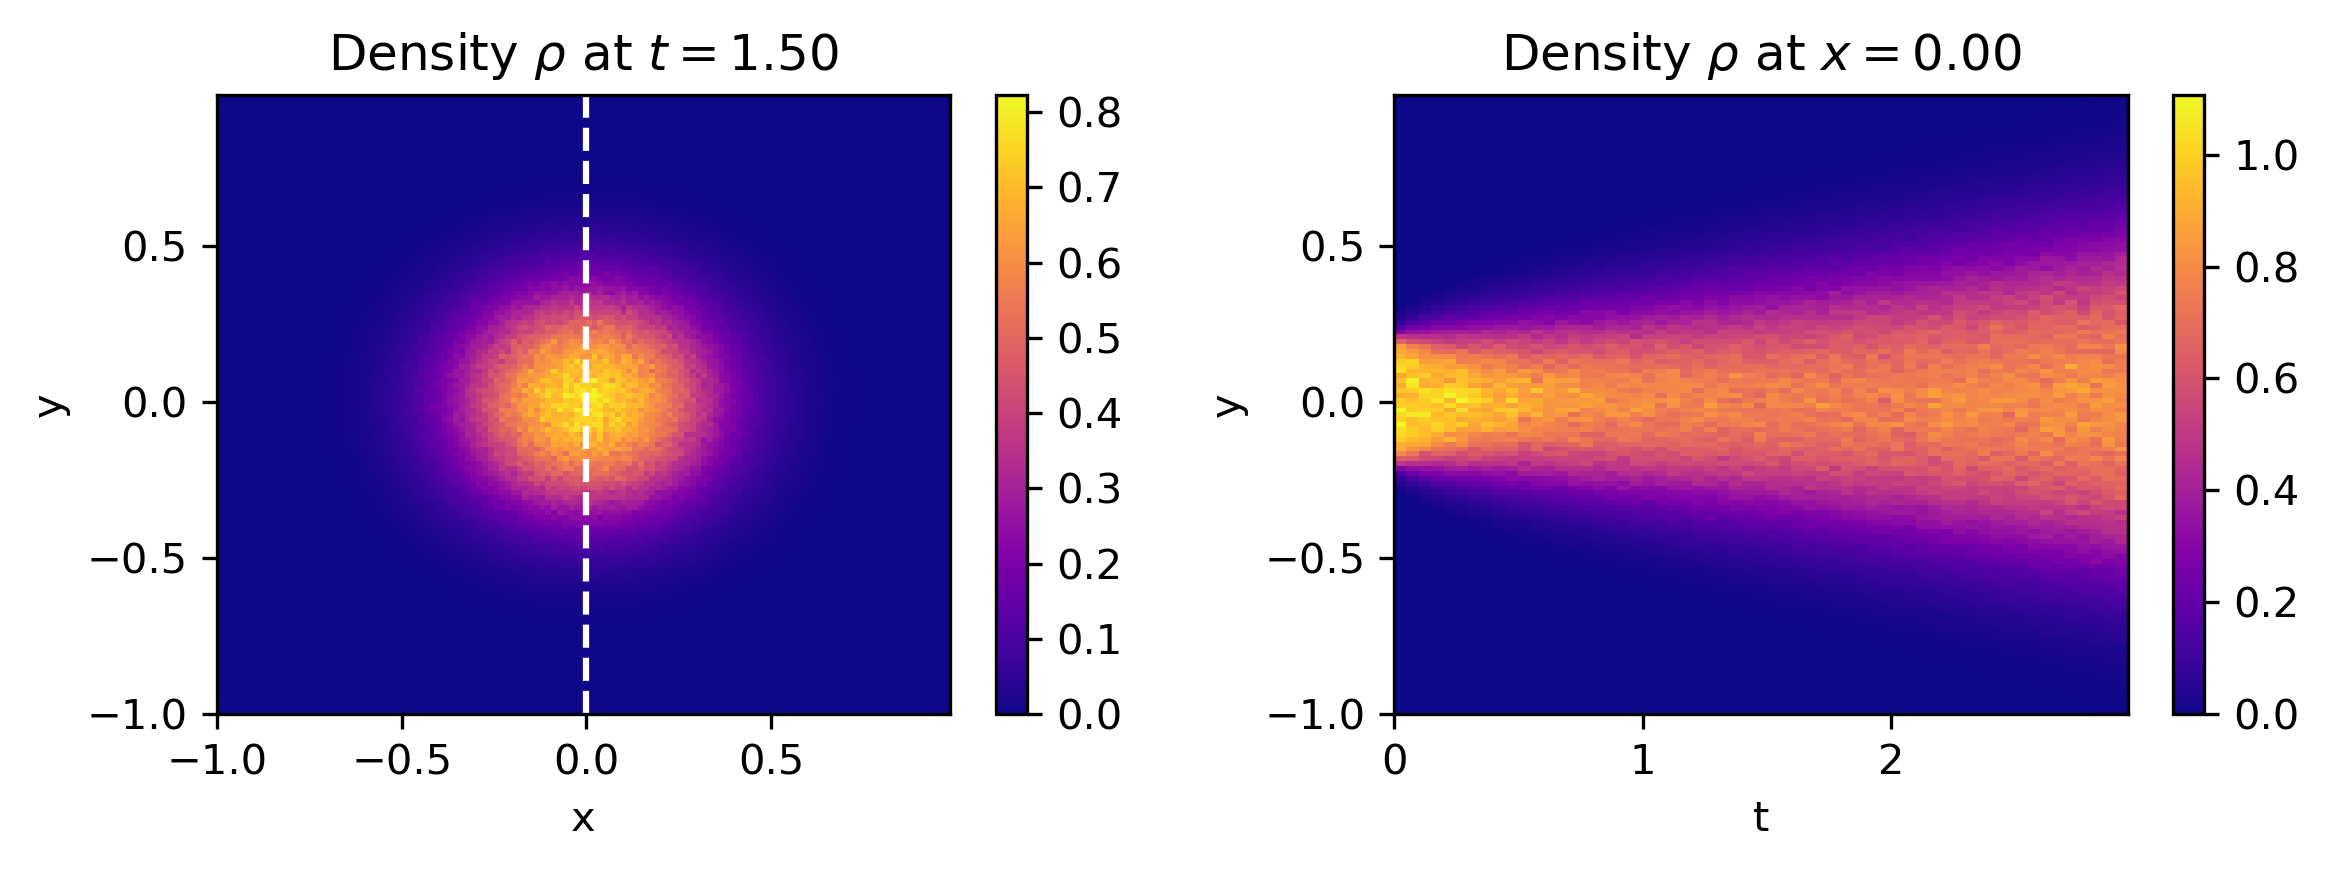

In [23]:
plt.figure(figsize=(8,3), dpi=300)
ind_t = 30
ind_x = 64

plt.subplot(121)
plt.pcolormesh(x, y, data_raw['rho'][ind, :, :], cmap='plasma')
plt.colorbar()
plt.axvline(0, linestyle='--', color='w')
plt.title(r'Density $\rho$ at $t=%0.2f$' %(t[ind_t]))
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(122)
plt.pcolormesh(t, y, data_raw['rho'][:, ind_x, ].T, cmap='plasma')
plt.colorbar()
plt.title(r'Density $\rho$ at $x=%0.2f$' %(x[ind_x]))
plt.xlabel('t')
plt.ylabel('y')

plt.tight_layout()

### Make a video of the dynamics 

2021-02-24 22:40:53,379:matplotlib.animation:INFO: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1500x1200', '-pix_fmt', 'rgba', '-r', '15', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-metadata', 'title=Fields Movie', '-metadata', 'artist=Matplotlib', '-metadata', 'comment=Movie support!', '-y', 'data/PDElearn/noise0.05-stridge/rho_movie.mp4']
100%|██████████| 60/60 [00:04<00:00, 13.58it/s]


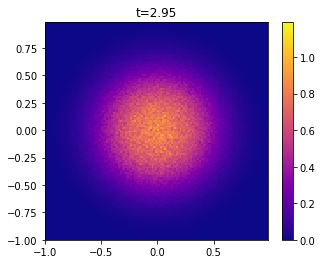

In [24]:
from matplotlib.animation import FFMpegWriter

metadata = dict(title='Fields Movie', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)
dpi = 300

rho = data_raw['rho']*np.random.normal(1, std_dev, data_raw['rho'].shape)
rho_max_lim = np.max(rho)
rho_min_lim = np.min(rho)

fig = plt.figure(figsize=(5,4))
ax = plt.axes()
img = plt.pcolormesh(x,y,rho[0, :, :], vmin=rho_min_lim, vmax=rho_max_lim, cmap='plasma'); plt.colorbar()
step = 20

skip = 0
with writer.saving(fig, "%s/rho_movie.mp4" %(save_path), dpi):
    for count, i in enumerate(tqdm(range(0,nt,skip+1))):
        img.set_array(rho[i, :, :][:-1,:-1].ravel())
        ax.set_title('t=%0.2f' %(t[i]))
        
        writer.grab_frame()

### Here, we define the base features/library terms to be included
Other library terms are generated by multiplying these features with powers of $\rho$ as shown later.

In [25]:
#define features
#(include a * between raw features that need to be multiplied)
features = ['1', 'rho_x', 'rho_y', 'rho_xx', 'rho_yy', 'rho_xy'] 

### Generate pdel model by providing it with data and the training labels 

In [37]:
#reload the module 
importlib.reload(pdel)
model = pdel.PDElearn('rho', 'rho_t', features, data_cv, poly_order=order, \
                      print_flag = False, sparse_algo=algo, \
                      path=save_path)

print('The features are shown below:\n')
print(model.Theta_desc)

The features are shown below:

['rho^1', 'rho^2', 'rho^3', 'rho_x', 'rho^1 rho_x', 'rho^2 rho_x', 'rho^3 rho_x', 'rho_y', 'rho^1 rho_y', 'rho^2 rho_y', 'rho^3 rho_y', 'rho_xx', 'rho^1 rho_xx', 'rho^2 rho_xx', 'rho^3 rho_xx', 'rho_yy', 'rho^1 rho_yy', 'rho^2 rho_yy', 'rho^3 rho_yy', 'rho_xy', 'rho^1 rho_xy', 'rho^2 rho_xy', 'rho^3 rho_xy']


### Perform cross-validation after defining the hyperparameter interval range

In [44]:
#hyper-parameters to sweep
lambda_min, lambda_max = get_lambda_lims(*scale_X_y(model.Theta, model.ft), 0.1)
lam1_arr = np.logspace(np.log10(lambda_min), np.log10(lambda_max), nlam1)
lam2_arr = np.logspace(-2, 3, nlam2)

#cross validate
model.run_cross_validation(lam1_arr, lam2_arr, n_cores=num_cores, \
                           n_folds=n_folds, n_repeats=n_repeats, maxit=num_iters, plot_folds=True);

#find the relaxed intersection set of the learned PDEs 
model.find_intersection_of_folds(thresh=stab_thresh, plot_hist=False);

2021-02-24 23:03:08,878:pdel.pdelearn:INFO: Spase solver selected: stridge
2021-02-24 23:03:08,882:pdel.pdelearn:INFO: Running cross validation: 4 folds, 25 repeats
100%|██████████| 100/100 [00:14<00:00,  7.33it/s]
2021-02-24 23:03:56,794:pdel.pdelearn:INFO: Cross Validation done!
2021-02-24 23:03:56,795:pdel.pdelearn:INFO: Finding the intersection set of PDEs from the folds!


### Find the Pareto front and print the PDEs

As we see below, the correct PDE is discovered below. Due to the combination of cross-validation and construction of the Pareto front based on the test area, we are left with only one PDE, which is the true one. 

Log(loss) = 0.084829
score = 1.000
complexity = 4.000
rho_t = (0.99076)rho^1
  + (-0.97966)rho^2
  + (0.01014)rho_xx
  + (0.00995)rho_yy
 


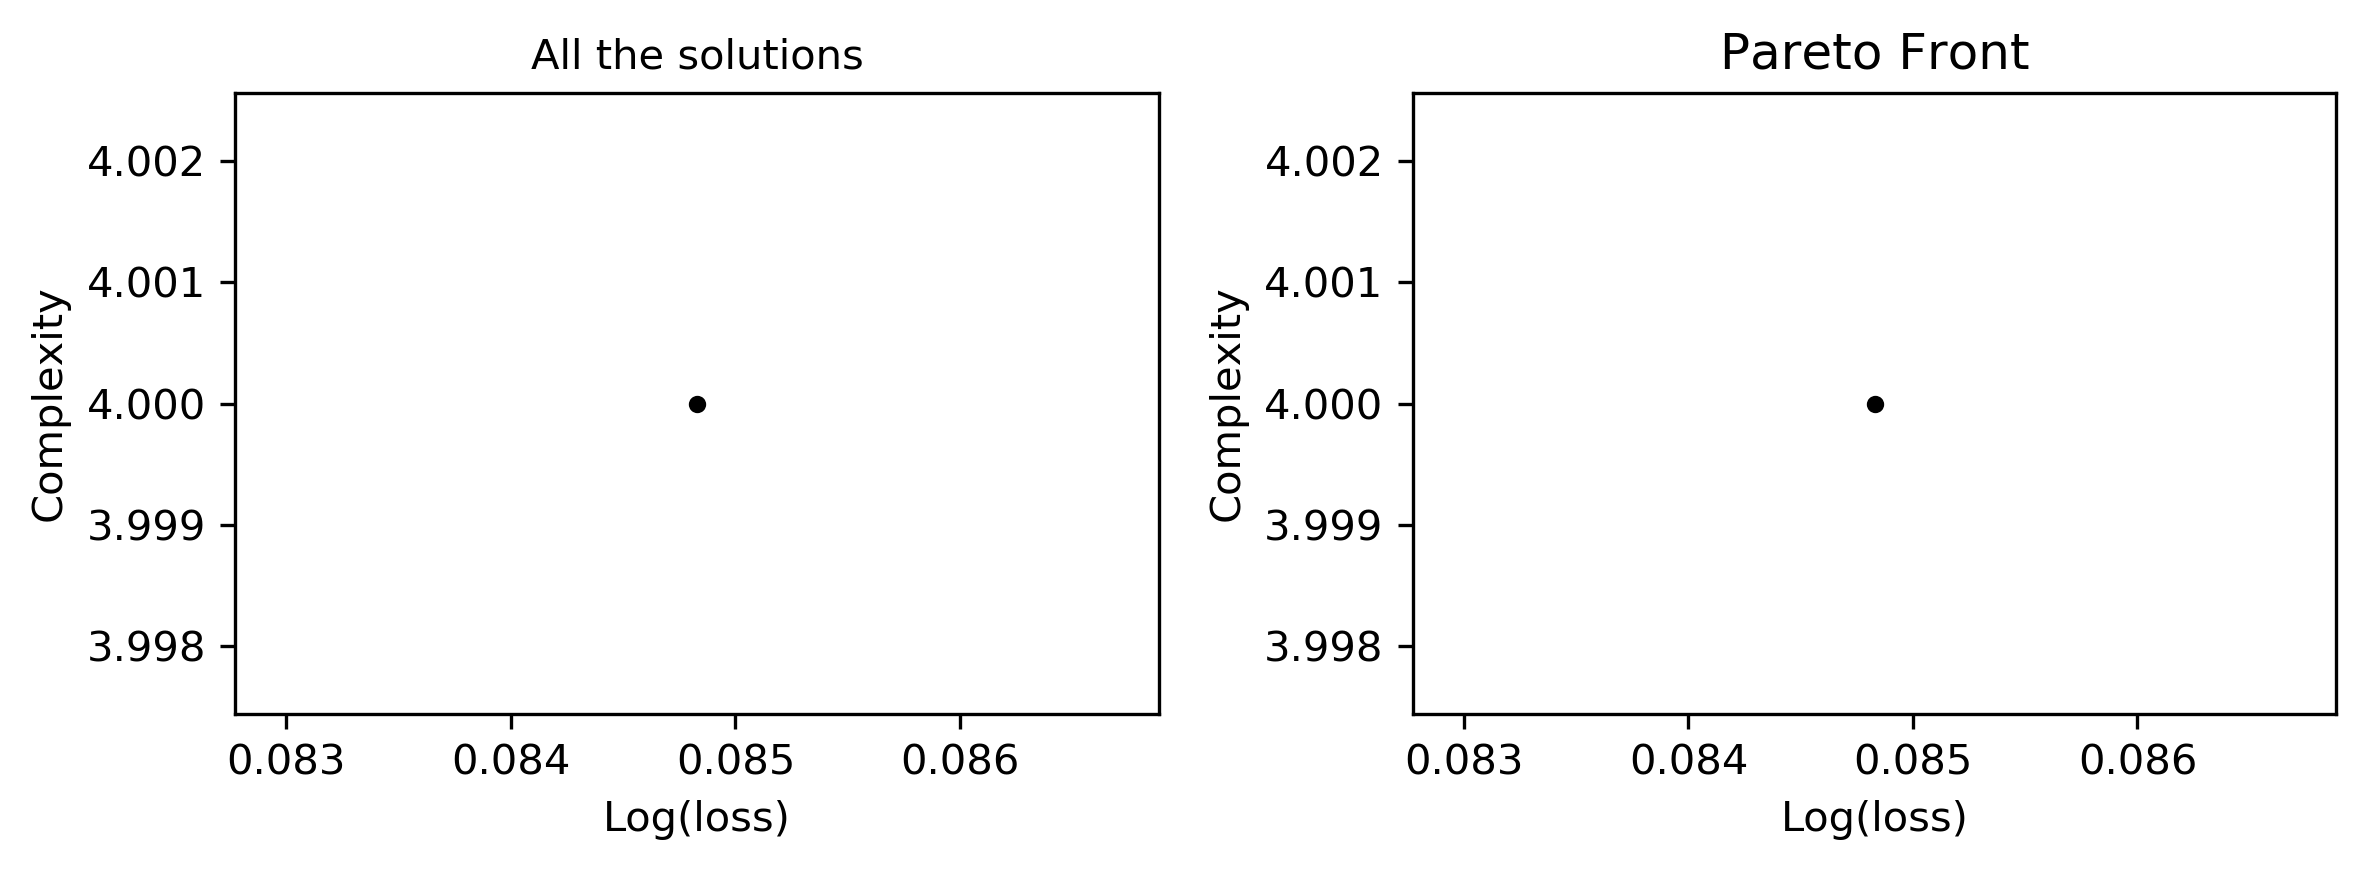

In [45]:
model.find_pareto(plot_fig=True)

model.print_pdes(model.pareto_coeffs, model.pareto_errors, score=model.pareto_scores, \
                 complexity=model.pareto_complexity, file_name_end='intersect')

### Use stability selection to observe the stability of the features and choose models based on a threshold

This is yet another way to choose models. It provides a graphical way to investigate which terms are 'stable'. We look at the 'stability score' of each term, which is the fraction of folds in which the term was found. 

Through the stability plot, we can see that the most relevant terms jump to a stability score of 1 as the hyperparameter (threshold in the STRidge algorithm) is decreased. Along this stability path, all the unique PDEs above the stability threshold are printed. 

Log(loss) = 1.371029
complexity = 3.000
rho_t = (1.15840)rho^1
  + (-1.43255)rho^2
  + (0.00976)rho_yy
 
Log(loss) = -0.281876
complexity = 4.000
rho_t = (0.99076)rho^1
  + (-0.97966)rho^2
  + (0.01014)rho_xx
  + (0.00995)rho_yy
 


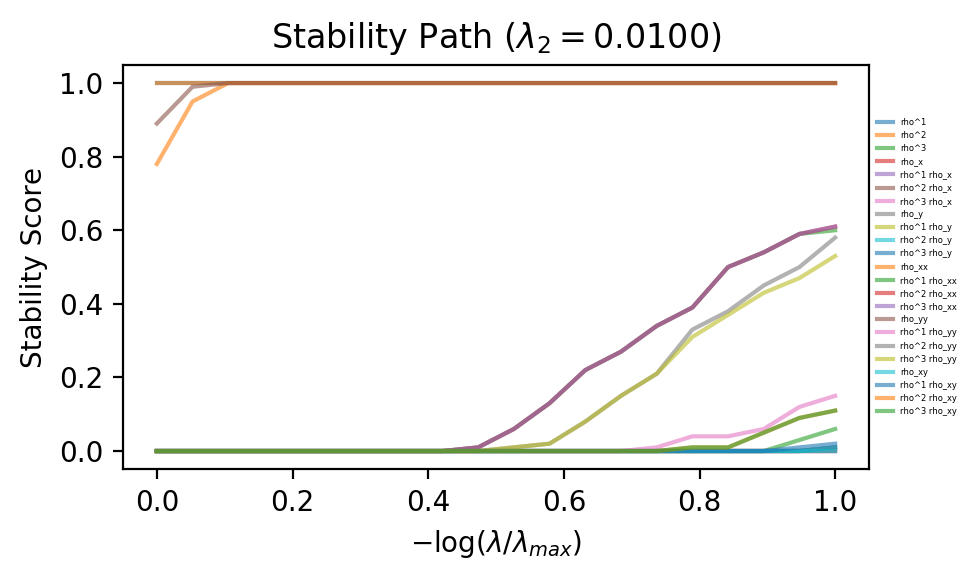

In [46]:
#stability selection 
coeffs_all, error_all, _, complexity = model.select_stable_components(thresh=stab_thresh, plot_stab=True)
model.print_pdes(coeffs_all, error_all, complexity=complexity, file_name_end='stability')

### In conclusion, both the cross-validation and the stability selection approaches are able to robustly determine the correct PDE. 

```
rho_t = (0.99076)rho^1
    + (-0.97966)rho^2
    + (0.01014)rho_xx
    + (0.00995)rho_yy
```

